# Regression

Based on feedback from our TF, we attempted several forms of regression to see how well we could predict numerical graduation rate with school district characteristics alone, then with previous years graduation rates, then with school district characteristics and previous years graduation rates.

One opportunity in this space is that the U.S. Department of Education typically delays making graduation rate data available.  For instance, it is the 2015-2016 school year, and the most current graduation rate data available is for the year 2009-2010.  If we could build a model to predict graduation rate for the years of missing data, organizations that rely on graduation rate data to provide schools services could use this graduation rate approximation until newer graduation rate data becomes available.

For this notebook, we pulled 3 previous years of graduation rate data (2006-2007, 2007-2008, and 2008-2009).  First we built regression models using school district data alone and predicting numerical graduation rate, then we built regression models using historic graduation rate data alone and predicting numerical graduation rate, then we built regression models using school district data and historic graduation rate data and predicting numerical graduation rate, and lastly we built a regression model using 2006-2007 school district data and fed it new 2009-2010 school district data to see how well it would predict 2009-2010 numerical graduation rate.

In [1588]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [1589]:
fullprevyears = pd.read_csv("data/finaldata/dftouse_withprevyears.csv")

In [1590]:
dftouse = fullprevyears.copy(deep=True)

In [1591]:
dftouse.shape

(10785, 160)

In [1592]:
dftouse.head()

,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,1,1,1,360,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0,0,0,0.000000,0,1,NaN,NaN,NaN
1,1,1,1,594,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,1,0,100.0,100.0,100.0
2,1,1,1,1033,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0,0,0,0.000000,0,1,75.6,41.4,NaN
3,3,0,3,432,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,70.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.000000,0,0,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0,0,0,0.000000,0,1,97.1,81.6,83.3
4,2,0,2,595,15.64,13.37,10718,5634,4020,1065,4944,2103,336,4703,1438,11586,2769,0,7384,4944,19.5,67.0,4.6,63.7,28.5,9.9,52.6,37.5,95.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0.061464,0,0,0.000000,0.043101,0.000000,0,0.034175,0.008926,0.004336,0.002805,0,0.004081,0.066820,0.000000,0.000000,0.004081,0,0.00000,0.859543,0.000000,0.000000,0.118656,0.000000,0.002144,0,0,0.000000,0.001072,0.018585,0.000000,0.000000,0,0.095816,0.107962,0.1

In [1593]:
STANDARDIZABLE = ['num_students', 'num_schools','num_charter_schools','num_pub_schools','tcuresal_percent','pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp','tlocrev_pp','tsrev_pp','tfedrev_pp','tcurinst_pp','tcurssv_pp','tcuroth_pp','tcursalary_pp','tcurbenefits_pp','totalexp_pp','tcapout_pp','tnonelse_pp','tcurelsc_pp','instexp_pp','tcurinst_percent','tcuroth_percent','tcurelsc_percent','tcurssvc_percent','tfedrev_percent','tlocrev_percent','tsrev_percent','r_ELL','r_IEP','r_lunch_free','r_lunch_reduced','r_stud_PKK','r_stud_18','r_stud_912','r_stud_re_M','r_stud_re_F','r_stud_re_AIAN','r_stud_re_AAP','r_stud_re_H','r_stud_re_B','r_stud_re_W','r_stud_re_HNPI','r_stud_re_Two','r_stud_re_Total','r_stud_reg_12_AIAN_M','r_stud_reg_12_AIAN_F','r_stud_reg_12_AAP_M','r_stud_reg_12_AAP_F','r_stud_reg_12_H_M','r_stud_reg_12_H_F','r_stud_reg_12_B_M','r_stud_reg_12_B_F','r_stud_reg_12_W_M','r_stud_reg_12_W_F','r_stud_reg_12_HNPI_M','r_stud_reg_12_HNPI_F','r_stud_reg_12_Two_M','r_stud_reg_12_Two_F','r_st_PKT','r_st_KT','r_st_ET','r_st_ST','r_st_UT','r_st_TS','r_st_IA','r_st_IC','r_st_EGC','r_st_SGC','r_st_OGC','r_st_TGC','r_st_LMS','r_st_LMSS','r_st_LEA','r_st_LEASS','r_st_SA','r_st_SASS','r_st_SSSS','r_st_OSSS','r_lrev_pt','r_lrev_gst','r_lrev_put','r_lrev_it','r_lrev_aot','r_lrev_pgc','r_lrev_cc','r_lrev_oss','r_lrev_tui','r_lrev_trans','r_lrev_slr','r_lrev_ts','r_lrev_sar','r_lrev_osalserv','r_lrev_sfns','r_lrev_ie','r_lrev_molr','r_lrev_sp','r_lrev_rr','r_lrev_sale','r_lrev_ff','r_lrev_pc','r_srev_gfa','r_srev_sep','r_srev_trans','r_srev_sip','r_srev_cbsp','r_srev_vep','r_srev_codsp','r_srev_bep','r_srev_gt','r_srev_slp','r_srev_aor','r_srev_splea','r_srev_osp','r_srev_ns','r_frev_title1','r_frev_dis','r_frev_cna','r_frev_ems','r_frev_dfs','r_frev_voc','r_frev_ao','r_frev_ns','r_frev_ia','r_frev_be','r_frev_na','r_frev_aofed']
print STANDARDIZABLE

['num_students', 'num_schools', 'num_charter_schools', 'num_pub_schools', 'tcuresal_percent', 'pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp', 'tlocrev_pp', 'tsrev_pp', 'tfedrev_pp', 'tcurinst_pp', 'tcurssv_pp', 'tcuroth_pp', 'tcursalary_pp', 'tcurbenefits_pp', 'totalexp_pp', 'tcapout_pp', 'tnonelse_pp', 'tcurelsc_pp', 'instexp_pp', 'tcurinst_percent', 'tcuroth_percent', 'tcurelsc_percent', 'tcurssvc_percent', 'tfedrev_percent', 'tlocrev_percent', 'tsrev_percent', 'r_ELL', 'r_IEP', 'r_lunch_free', 'r_lunch_reduced', 'r_stud_PKK', 'r_stud_18', 'r_stud_912', 'r_stud_re_M', 'r_stud_re_F', 'r_stud_re_AIAN', 'r_stud_re_AAP', 'r_stud_re_H', 'r_stud_re_B', 'r_stud_re_W', 'r_stud_re_HNPI', 'r_stud_re_Two', 'r_stud_re_Total', 'r_stud_reg_12_AIAN_M', 'r_stud_reg_12_AIAN_F', 'r_stud_reg_12_AAP_M', 'r_stud_reg_12_AAP_F', 'r_stud_reg_12_H_M', 'r_stud_reg_12_H_F', 'r_stud_reg_12_B_M', 'r_stud_reg_12_B_F', 'r_stud_reg_12_W_M', 'r_stud_reg_12_W_F', 'r_stud_reg_12_HNPI_M', 'r_stud_r

In [1594]:
INDICATORS = []
for v in dftouse.columns:
    l=np.unique(dftouse[v])
    if len(l) <= 10:
        INDICATORS.append(v)
        
INDICATORS.remove('RESP_High_Graduation')        
INDICATORS.remove('RESP_Low_Graduation')  
print INDICATORS

['i_agency_type_local_school_district', 'i_agency_type_local_school_district_sup_union', 'i_agency_type_regional_education_services', 'i_agency_type_charter_school_agency', 'i_fin_sdlc_sec', 'i_fin_sdlc_elem_sec', 'i_fin_sdlc_voc', 'i_ucl_city_large', 'i_ucl_city_mid', 'i_ucl_city_small', 'i_ucl_suburb_large', 'i_ucl_suburb_mid', 'i_ucl_suburb_small', 'i_ucl_town_fringe', 'i_ucl_town_distant', 'i_ucl_town_remote', 'i_ucl_rural_fringe', 'i_ucl_rural_distant', 'i_ucl_rural_remote', 'i_cs_all_charter', 'i_cs_charter_noncharter', 'i_cs_all_noncharter', 'i_ma_ne_nr', 'i_ma_metropolitan', 'i_ma_micropolitan', 'i_lgo_K', 'i_lgo_PK']


In [1595]:
#CITATION: From HW3
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [1596]:
#CITATION: From HW3
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [1597]:
# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dftouse['afgr'][mask])
print "% Graduation in Testing:", np.mean(dftouse['afgr'][~mask])

% Graduation in Training: 82.5978010332
% Graduation in Testing: 82.9122064277


In [1598]:
#CITATION: From HW3
mask

array([ True, False,  True, ...,  True,  True,  True], dtype=bool)

In [1599]:
#CITATION: From HW3
mask.shape, mask.sum()

((10785,), 7549)

In [1600]:
dftouse.head()

,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,1,1,1,360,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0,0,0,0.000000,0,1,NaN,NaN,NaN
1,1,1,1,594,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,1,0,100.0,100.0,100.0
2,1,1,1,1033,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0,0,0,0.000000,0,1,75.6,41.4,NaN
3,3,0,3,432,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,70.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.000000,0,0,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0,0,0,0.000000,0,1,97.1,81.6,83.3
4,2,0,2,595,15.64,13.37,10718,5634,4020,1065,4944,2103,336,4703,1438,11586,2769,0,7384,4944,19.5,67.0,4.6,63.7,28.5,9.9,52.6,37.5,95.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0.061464,0,0,0.000000,0.043101,0.000000,0,0.034175,0.008926,0.004336,0.002805,0,0.004081,0.066820,0.000000,0.000000,0.004081,0,0.00000,0.859543,0.000000,0.000000,0.118656,0.000000,0.002144,0,0,0.000000,0.001072,0.018585,0.000000,0.000000,0,0.095816,0.107962,0.1

In [1601]:
#CITATION: From HW3
from sklearn.preprocessing import StandardScaler

for col in STANDARDIZABLE:
    #print col
    valstrain=dftouse[col].values[mask]
    valstest=dftouse[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out

In [1602]:
dftouse.head()

,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,-0.354018,0.348397,-0.354472,-0.272595,0.353207,0.673504,-0.230363,-1.026451,0.522658,0.595902,-0.911577,0.364978,-0.135398,-0.770909,-0.908185,-0.228767,0.262713,-0.080019,-0.341876,-0.911577,-1.390696,-1.922947,0.149935,-1.396337,2.601045,1.781954,-1.797741,1.350488,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,-0.257149,-0.252707,-0.256780,0.312886,3.287635,-0.230933,-0.060135,0.448415,-0.269222,-0.518308,-0.237888,-0.066417,-0.388568,0.282122,-0.169413,-0.193650,22.317499,-0.267388,-0.202584,1.020454,-0.604845,-0.474252,-0.275896,-0.294638,-0.287297,-0.306734,-0.08642,1.061158,-0.401331,-0.428838,-0.469157,-0.313631,-0.161542,3.229693,-1.033265,-0.228180,-0.814012,-0.272668,-0.251687,-0.597794,0.115776,-0.211068,-0.167179,-0.172312,-0.425572,0,1,NaN,NaN,NaN
1,-0.376334,0.287358,-0.374176,-0.281339,2.907425,2.753227,-0.298043,0.954207,-1.431276,-0.596750,-0.508037,-0.328244,-1.683753,-0.681925,-0.569981,-0.507541,-0.201013,-0.162097,-0.529607,-0.508037,-0.315198,0.382044,-2.365474,-0.760727,0.397472,-1.583444,2.867209,-2.499860,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,-0.252948,-0.269053,-0.266655,-0.341962,8.637428,0.093293,-0.136004,-0.867474,-0.305684,-0.509826,-0.250843,-0.076109,-0.338106,-0.377055,-0.226415,-0.178199,-0.128508,-0.262825,-0.193101,-3.193317,-0.597067,-0.492916,14.430389,-0.395097,-0.279047,-0.330242,-0.12425,-0.153892,-0.367064,-0.254740,-0.475415,-0.202435,-0.170912,-1.660725,-1.015241,-2.113150,-0.759315,-0.252327,-0.302982,-1.411895,-0.401444,-0.207163,-0.194425,-0.183195,-0.433206,1,0,100.0,100.0,100.0
2,-0.354018,0.348397,-0.354472,-0.223255,0.573320,0.543679,-0.243025,-1.084914,0.841484,0.108448,-0.585216,-0.149673,-0.110862,-0.207511,-1.335250,-0.522707,-0.458785,-0.187965,-0.403996,-0.585216,-2.338768,-0.515295,0.253948,0.714002,0.758877,0.530540,-1.926026,2.011712,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,-0.257149,-0.252707,-0.256780,-0.332442,-0.397729,-0.230933,-0.060135,16.321712,-0.269222,-0.518308,-0.237888,-0.066417,3.987678,-0.486401,-0.245320,2.690476,-0.106079,-0.267388,-0.202584,0.966752,-0.604845,-0.474252,-0.275896,-0.403655,-0.287297,-0.306734,-0.08642,-0.203371,-0.357847,-0.603059,-0.029712,-0.139339,-0.161542,1.174718,-0.679584,0.729270,0.322164,-0.272668,-0.251687,0.067874,-0.402643,-0.211068,-0.167179,-0.172312,-0.425572,0,1,75.6,41.4,NaN
3,-0.251481,-0.101184,-0.252912,-0.267316,-0.515779,-0.565960,-0.196595,-0.210813,-0.207117,0.164316,-0.605072,0.329455,0.168840,-0.223511,-0.068005,0.023596,0.341911,-0.189485,-

In [1603]:
#CITATION: From HW3
lcols=list(dftouse.columns)
lcols.remove('RESP_High_Graduation')
lcols.remove('RESP_Low_Graduation')
lcols.remove('afgr')
lcols.remove('gradrate0607')
lcols.remove('gradrate0708')
lcols.remove('gradrate0809')
###Check for Index Column if exixts in data and remove.
indexcol='Unnamed: 0'
if indexcol in list(dftouse.columns): lcols.remove(indexcol)
print len(lcols)

154


In [1604]:
#CITATION: From HW3
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)
print len(ccols), len(INDICATORS)
ccols

127 27


['num_schools',
 'num_charter_schools',
 'num_pub_schools',
 'num_students',
 'pupil_teacher_ratio_dist',
 'pupil_teacher_ratio_ps',
 'totalrev_pp',
 'tlocrev_pp',
 'tsrev_pp',
 'tfedrev_pp',
 'tcurinst_pp',
 'tcurssv_pp',
 'tcuroth_pp',
 'tcursalary_pp',
 'tcurbenefits_pp',
 'totalexp_pp',
 'tcapout_pp',
 'tnonelse_pp',
 'tcurelsc_pp',
 'instexp_pp',
 'tcurelsc_percent',
 'tcurinst_percent',
 'tcuroth_percent',
 'tcuresal_percent',
 'tcurssvc_percent',
 'tfedrev_percent',
 'tlocrev_percent',
 'tsrev_percent',
 'r_ELL',
 'r_IEP',
 'r_lunch_free',
 'r_lunch_reduced',
 'r_stud_PKK',
 'r_stud_18',
 'r_stud_912',
 'r_stud_re_M',
 'r_stud_re_F',
 'r_stud_re_AIAN',
 'r_stud_re_AAP',
 'r_stud_re_H',
 'r_stud_re_B',
 'r_stud_re_W',
 'r_stud_re_HNPI',
 'r_stud_re_Two',
 'r_stud_re_Total',
 'r_stud_reg_12_AIAN_M',
 'r_stud_reg_12_AIAN_F',
 'r_stud_reg_12_AAP_M',
 'r_stud_reg_12_AAP_F',
 'r_stud_reg_12_H_M',
 'r_stud_reg_12_H_F',
 'r_stud_reg_12_B_M',
 'r_stud_reg_12_B_F',
 'r_stud_reg_12_W_M',
 

In [1605]:
Xmatrix=dftouse[lcols].values
Yresp=dftouse['afgr'].values

In [1606]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression

In [1607]:
import sklearn.linear_model
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1608]:
print lm.intercept_
print lm.coef_

134097545.562
[  5.37068457e+00   4.17479148e-01  -7.75853310e+00   1.68793952e+00
  -3.06059597e-01   2.81525313e-01  -4.35593270e+02   2.84042636e+02
   2.22860396e+02   1.24448864e+02  -5.01339838e+07   4.70719247e+02
   4.09766335e+01  -1.65836388e+00  -5.81240681e-01  -3.65828862e+00
   1.39581460e+00   1.66909040e-02  -9.79152346e+02   5.01345349e+07
  -2.86624246e-01  -6.71803501e+00  -1.05317053e+00   8.90646185e-01
  -6.02542610e+00  -5.93876744e-02   5.26783159e+00   3.95854889e+00
   8.07951163e-01   8.34212155e-01  -5.87412659e+00  -1.51626017e+08
   8.15608327e+00   1.04126745e+01   8.35133567e+00   1.53264652e+07
   1.53264644e+07   1.53264651e+07   1.53264676e+07   1.53264665e+07
   1.53264669e+07   1.53264674e+07   1.53264666e+07   1.53264659e+07
   1.53264666e+07   1.53264667e+07   1.53264676e+07   8.81925203e+07
  -6.34334936e+07  -6.34334922e+07  -8.59904606e+07  -8.59904613e+07
  -8.59904614e+07   1.31732601e+01   1.30248297e+01  -5.43322880e-02
  -4.59765302e+00  -

<b>Top Factors - Positive</b>

In [1609]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:25]

,features,estimatedCoefficients
95,r_st_SGC,5.023686e+11
68,r_stud_re_W,8.604052e+10
66,r_stud_re_H,5.872589e+10
67,r_stud_re_B,5.685727e+10
64,r_stud_re_AIAN,3.249830e+10
96,r_st_OGC,2.772841e+10
94,r_st_EGC,1.801168e+10
65,r_stud_re_AAP,1.329447e+10
70,r_stud_re_Two,7.606463e+09
69,r_stud_re_HNPI,8.753174e+08


<b>Top Factors - Negative</b>

In [1610]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:25]

,features,estimatedCoefficients
97,r_st_TGC,-5.025443e+11
71,r_stud_re_Total,-1.668868e+10
31,i_agency_type_charter_school_agency,-1.516260e+08
52,i_ma_micropolitan,-8.599046e+07
51,i_ma_metropolitan,-8.599046e+07
50,i_ma_ne_nr,-8.599046e+07
48,i_cs_charter_noncharter,-6.343349e+07
49,i_cs_all_noncharter,-6.343349e+07
10,tcurinst_pp,-5.013398e+07
18,tcurelsc_pp,-9.791523e+02


r2

In [1611]:
from sklearn import cross_validation
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.32976199,  0.13670807,  0.37638992])

Mean Squared Error

In [1612]:
from sklearn.metrics import mean_squared_error
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

1.7925237543602161e+23

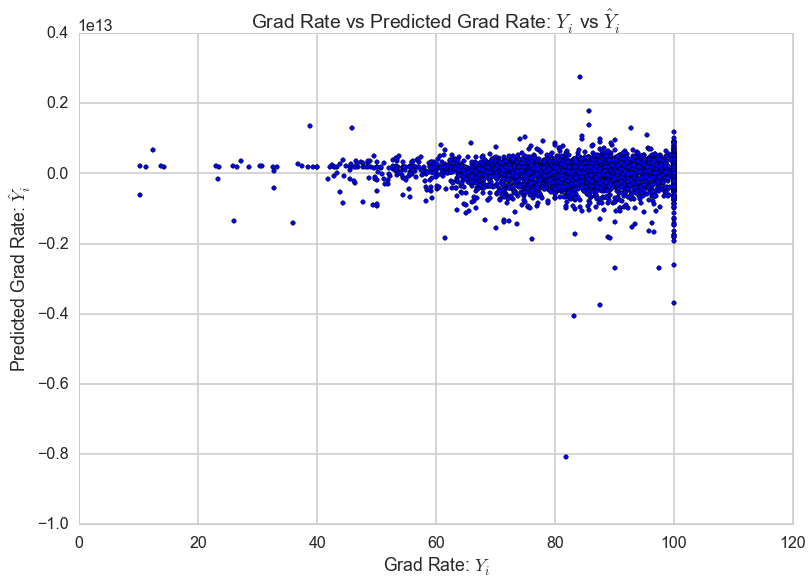

In [1613]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Lasso Regression

In [1614]:
lasso = linear_model.Lasso()

In [1615]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [1616]:
print lasso.coef_
print lasso.intercept_

[-0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.         -0.41179447 -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
  0.          0.          0.12700771 -0.         -0.          1.14233929
 -0.          0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.          0.
 -0.         -0.         -2.67272004  0.          0.         -0.          0.
 -0.          0.         -0.          0.         -0.         -1.65120436
  0.         -0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.          1.20737245
  1.65095258 -0.          0.          0.          0.          0.          0.
 -0.       

In [1617]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,1.650953
80,r_stud_reg_12_W_M,1.207372
26,tlocrev_percent,1.142339
106,r_lrev_pt,0.357678
23,tcuresal_percent,0.127008
0,num_schools,-0.000000
101,r_st_LEASS,-0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000


In [1618]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
57,r_lunch_free,-2.672720
67,r_stud_re_B,-1.651204
9,tfedrev_pp,-0.411794
111,r_lrev_pgc,-0.000000
110,r_lrev_aot,0.000000
109,r_lrev_it,0.000000
108,r_lrev_put,0.000000
113,r_lrev_oss,-0.000000
107,r_lrev_gst,-0.000000
98,r_st_LMS,-0.000000


r2

In [1619]:
from sklearn import cross_validation
cross_validation.cross_val_score(lasso, Xtrain, ytrain, scoring='r2')

array([ 0.29779104,  0.27190163,  0.28760353])

Mean Squared Error

In [1620]:
yp = lasso.predict(Xtest)
mean_squared_error(yp, ytest)

125.41670301651382

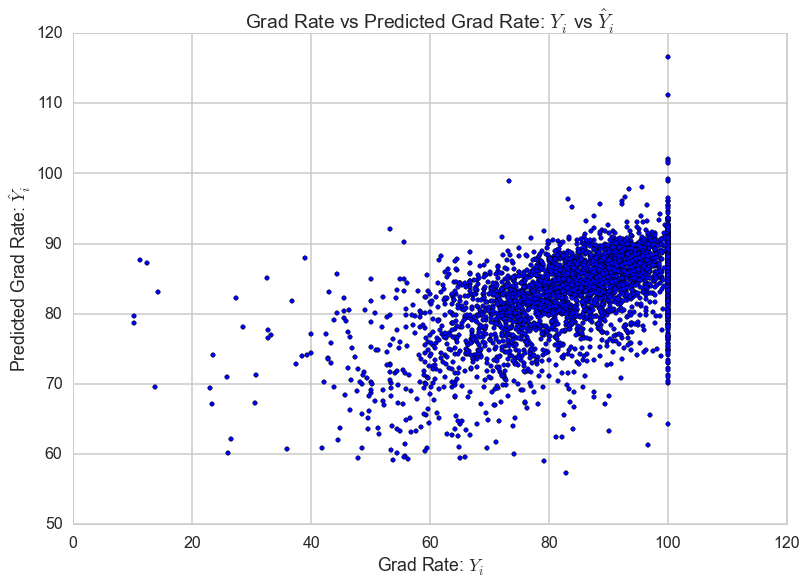

In [1621]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Elastic Net Regression

In [1622]:
elasticnet = linear_model.ElasticNet()
elasticnet.fit(Xtrain, ytrain)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [1623]:
print elasticnet.coef_
print elasticnet.intercept_

[ -1.62975927e-01  -0.00000000e+00  -1.65664034e-01  -0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00   0.00000000e+00
  -3.36729805e-01  -3.72963760e-01   0.00000000e+00  -0.00000000e+00
   3.87006265e-04  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00   3.55789510e-01   1.45411656e-01   3.43440395e-01
  -0.00000000e+00  -5.74348972e-01   8.70734991e-01  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -0.00000000e+00   0.00000000e+00  -1.92402109e-02
  -0.00000000e+00  -1.73456226e+00

In [1624]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:20]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,1.261829
80,r_stud_reg_12_W_M,1.122721
26,tlocrev_percent,0.870735
68,r_stud_re_W,0.833640
106,r_lrev_pt,0.500624
21,tcurinst_percent,0.355790
23,tcuresal_percent,0.343440
77,r_stud_reg_12_H_F,0.257661
75,r_stud_reg_12_AAP_F,0.248323
74,r_stud_reg_12_AAP_M,0.203172


In [1625]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:20]

,features,estimatedCoefficients
57,r_lunch_free,-1.734562
67,r_stud_re_B,-1.218214
25,tfedrev_percent,-0.574349
60,r_stud_18,-0.410090
9,tfedrev_pp,-0.372964
8,tsrev_pp,-0.336730
142,r_frev_title1,-0.265238
122,r_lrev_molr,-0.234642
107,r_lrev_gst,-0.225241
125,r_lrev_sale,-0.202599


In [1626]:
cross_validation.cross_val_score(elasticnet, Xtrain, ytrain, scoring='r2')

array([ 0.31186409,  0.28258043,  0.30783484])

In [1627]:
yp = elasticnet.predict(Xtest)
mean_squared_error(yp, ytest)

122.16178558394205

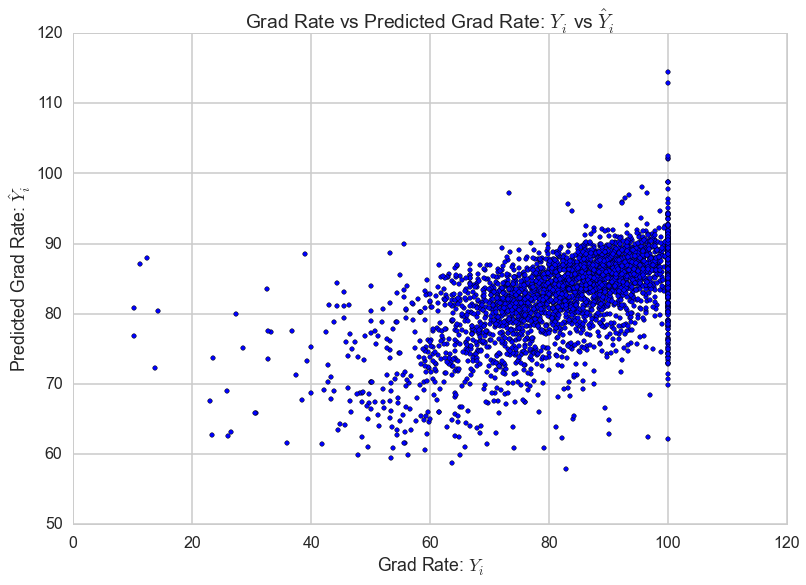

In [1628]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

## Predicting graduation based on previous year graduation

In [1629]:
dftouse.fillna(value=0,inplace=True)

In [1630]:
dftouse = dftouse[dftouse['gradrate0607']>0]
print 'Has 0607 Grad Data: ' + str(len(dftouse))
dftouse = dftouse[dftouse['gradrate0708']>0]
print 'Has 0708 Grad Data: ' + str(len(dftouse))
dftouse = dftouse[dftouse['gradrate0809']>0]
print 'Has 0809 Grad Data: ' + str(len(dftouse))

Has 0607 Grad Data: 10467
Has 0708 Grad Data: 10221
Has 0809 Grad Data: 9745


In [1631]:
dftouse.shape

(9745, 160)

In [1632]:
gradpred = dftouse.copy(deep=True)

In [1633]:
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [1634]:
#CITATION: From HW3
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [1635]:
# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dftouse['afgr'][mask])
print "% Graduation in Testing:", np.mean(dftouse['afgr'][~mask])

% Graduation in Training: 83.2412109661
% Graduation in Testing: 83.124247606


In [1636]:
Xmatrix=dftouse[['gradrate0607', 'gradrate0708', 'gradrate0809']].values
Yresp=dftouse['afgr'].values

In [1637]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression - 0607, 0708, and 0809

In [1638]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1639]:
print lm.intercept_
print lm.coef_

20.626888565
[ 0.16387891  0.24920475  0.35327643]


In [1640]:
pd.DataFrame(zip(dftouse[['gradrate0607', 'gradrate0708', 'gradrate0809']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0607,0.163879
1,gradrate0708,0.249205
2,gradrate0809,0.353276


In [1641]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.51196373,  0.50296364,  0.53000199])

In [1642]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

86.424496052909333

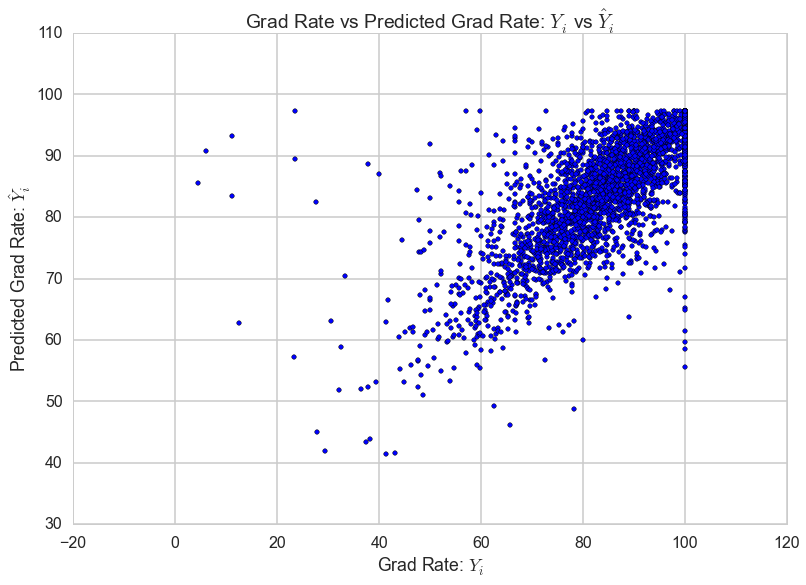

In [1643]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Linear Regression - 0708 and 0809

In [1644]:
Xmatrix=dftouse[['gradrate0708', 'gradrate0809']].values
Yresp=dftouse['afgr'].values

In [1645]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [1646]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1647]:
print lm.intercept_
print lm.coef_

22.9669984803
[ 0.32667733  0.41021646]


In [1648]:
pd.DataFrame(zip(dftouse[['gradrate0708', 'gradrate0809']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0708,0.326677
1,gradrate0809,0.410216


In [1649]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.49647038,  0.49001408,  0.51631986])

In [1650]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

87.574253417961245

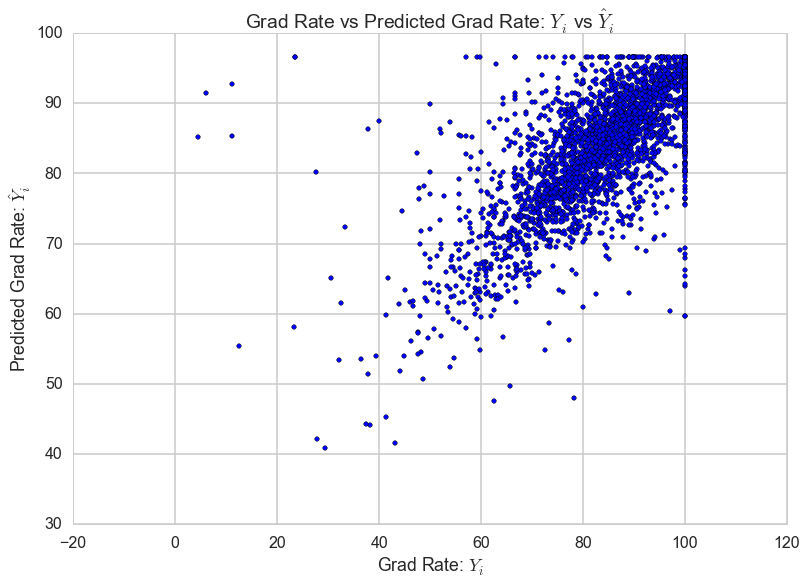

In [1651]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Linear Regression - 0809 Only

In [1652]:
Xmatrix=dftouse[['gradrate0809']].values
Yresp=dftouse['afgr'].values

In [1653]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [1654]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1655]:
print lm.intercept_
print lm.coef_

30.8063888118
[ 0.6393168]


In [1656]:
pd.DataFrame(zip(dftouse[['gradrate0809']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0809,0.639317


In [1657]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.43183401,  0.43020617,  0.44457332])

In [1658]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

96.64274956121595

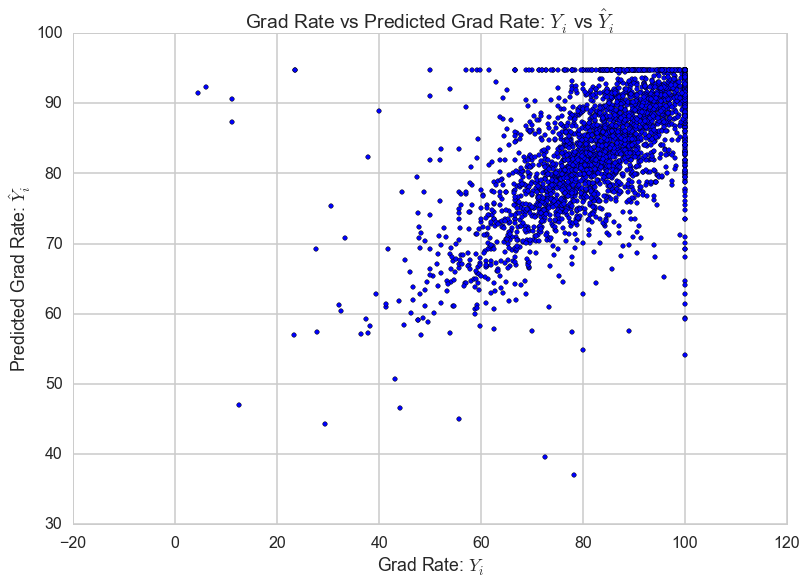

In [1659]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Linear Regression - 0708 Only

In [1660]:
Xmatrix=dftouse[['gradrate0708']].values
Yresp=dftouse['afgr'].values

In [1661]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [1662]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1663]:
print lm.intercept_
print lm.coef_

34.5873754679
[ 0.59686072]


In [1664]:
pd.DataFrame(zip(dftouse[['gradrate0708']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0708,0.596861


In [1665]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.39540385,  0.39979391,  0.41761331])

In [1666]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

105.33563394343845

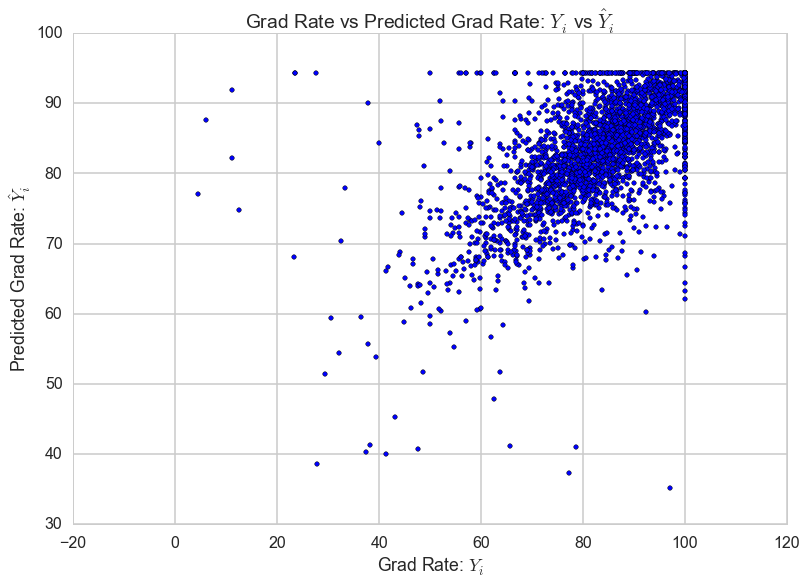

In [1667]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Linear Regression - 0607 Only

In [1668]:
Xmatrix=dftouse[['gradrate0607']].values
Yresp=dftouse['afgr'].values

In [1669]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [1670]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1671]:
print lm.intercept_
print lm.coef_

37.7965881525
[ 0.55888737]


In [1672]:
pd.DataFrame(zip(dftouse[['gradrate0607']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0607,0.558887


In [1673]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.36331188,  0.35156295,  0.36314115])

In [1674]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

115.89609014870315

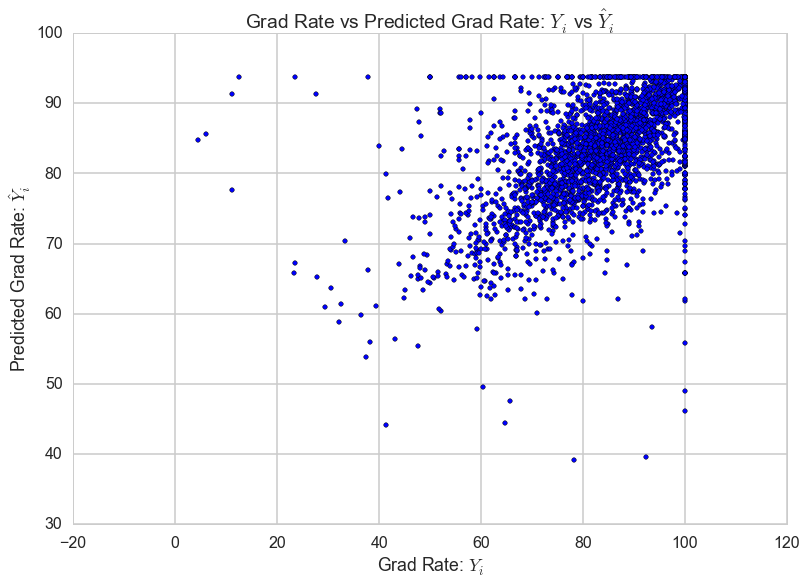

In [1675]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

## Predicting graduation based on previous year graduation and all other factors

In [1676]:
lcols=list(dftouse.columns)
lcols.remove('RESP_High_Graduation')
lcols.remove('RESP_Low_Graduation')
lcols.remove('afgr')

In [1677]:
Xmatrix=dftouse[lcols].values
Yresp=dftouse['afgr'].values

In [1678]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression

In [1679]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1680]:
print lm.intercept_
print lm.coef_

25.0467797196
[  5.47698856e-01   2.53556358e-01  -1.68825055e+00   7.48086363e-01
   5.47321712e-01  -2.33236718e-01  -1.64041498e+00   2.30047829e+00
   5.94793018e-01   1.04490722e+00   5.28832424e+00   1.22105233e+01
   1.00098611e+00  -2.67651845e+00  -6.26899386e-01  -2.34232832e+00
   8.83675662e-01   1.32847290e-01  -1.76572224e+01   5.28832424e+00
  -2.74891530e-01   1.35813420e+00   2.33070535e-01   7.68752521e-01
  -5.39379971e-01  -1.31159895e+00  -7.30718588e-01  -7.29786667e-01
  -8.66466450e-01  -2.70993548e+00  -8.12051874e+00  -1.31611644e+00
   5.11763024e+00   1.25295145e+01   7.65382465e+00  -8.24050589e-01
  -1.06389047e+00  -4.85218700e-01   6.07226824e-01   4.47666935e-01
   4.83511998e-01   1.60542126e+00  -2.85097652e-01  -5.02071026e-01
   1.55201099e-01  -3.01624161e-01   1.62924481e-01  -1.31611644e+00
   1.27762039e+00   3.84960493e-02   1.72770716e-01  -2.46401078e-01
   7.36303627e-02   1.38630707e+00   1.90108617e+00  -1.69717750e-01
   3.51325279e-01  -

In [1681]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)

,features,estimatedCoefficients
33,i_fin_sdlc_elem_sec,12.529514
11,tcurssv_pp,12.210523
91,r_st_TS,11.227736
68,r_stud_re_W,10.677540
66,r_stud_re_H,7.666721
34,i_fin_sdlc_voc,7.653825
67,r_stud_re_B,5.943099
148,r_frev_ao,5.590869
19,instexp_pp,5.288324
10,tcurinst_pp,5.288324


In [1682]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)

,features,estimatedCoefficients
18,tcurelsc_pp,-17.657222
89,r_st_ST,-9.470705
30,i_agency_type_regional_education_services,-8.120519
128,r_srev_gfa,-5.262388
100,r_st_LEA,-3.021953
29,i_agency_type_local_school_district_sup_union,-2.709935
13,tcursalary_pp,-2.676518
138,r_srev_aor,-2.637008
15,totalexp_pp,-2.342328
71,r_stud_re_Total,-2.279687


In [1683]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.51518257,  0.51302959,  0.55805391])

In [1684]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

91.207308898779445

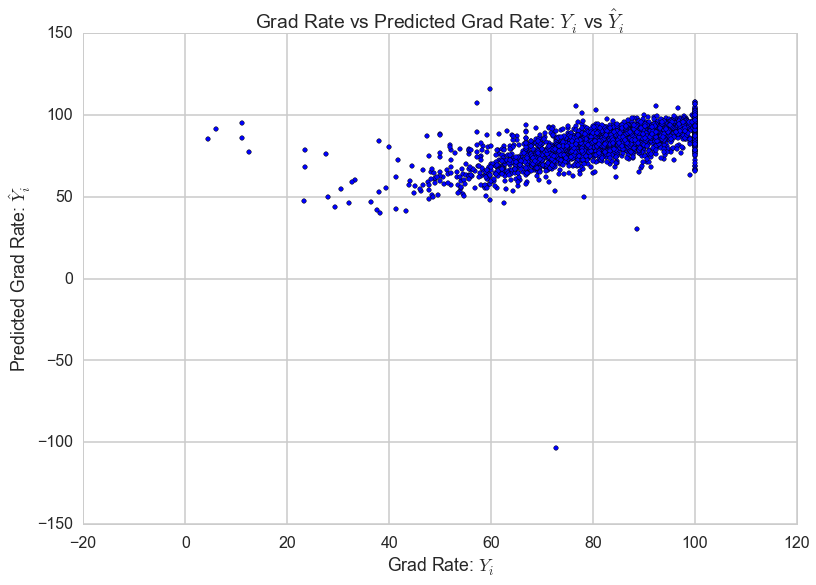

In [1685]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Lasso Regression

In [1686]:
lasso = linear_model.Lasso()

In [1687]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [1688]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,0.409637
156,gradrate0809,0.344030
155,gradrate0708,0.242018
154,gradrate0607,0.155173
108,r_lrev_put,-0.000000
101,r_st_LEASS,0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000
105,r_st_OSSS,0.000000


In [1689]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
57,r_lunch_free,-0.075813
100,r_st_LEA,-0.000000
101,r_st_LEASS,0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000
105,r_st_OSSS,0.000000
106,r_lrev_pt,0.000000
107,r_lrev_gst,-0.000000
108,r_lrev_put,-0.000000


In [1690]:
cross_validation.cross_val_score(lasso, Xtrain, ytrain, scoring='r2')

array([ 0.51893709,  0.5088733 ,  0.53604295])

In [1691]:
yp = lasso.predict(Xtest)
mean_squared_error(yp, ytest)

85.366126982227911

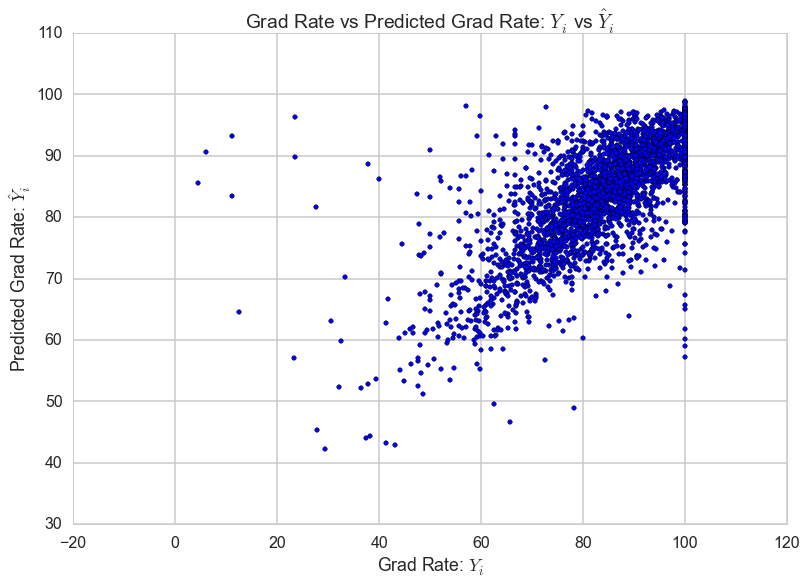

In [1692]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Elastic Net Regression

In [1693]:
elasticnet = linear_model.ElasticNet()
elasticnet.fit(Xtrain, ytrain)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [1694]:
print elasticnet.coef_
print elasticnet.intercept_

[-0.         -0.         -0.         -0.          0.          0.          0.
  0.02175385 -0.         -0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.04085725  0.23501782
 -0.          0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.         -0.          0.
 -0.          0.         -0.31612336 -0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.         -0.24202621
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.         -0.          0.33935336
  0.43353464 -0.          0.          0.          0.          0.         -0.
  0.       

In [1695]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,0.433535
80,r_stud_reg_12_W_M,0.339353
156,gradrate0809,0.331009
26,tlocrev_percent,0.235018
155,gradrate0708,0.230168
154,gradrate0607,0.141897
7,tlocrev_pp,0.021754
107,r_lrev_gst,-0.000000
101,r_st_LEASS,0.000000
102,r_st_SA,-0.000000


In [1696]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
57,r_lunch_free,-0.316123
67,r_stud_re_B,-0.242026
25,tfedrev_percent,-0.040857
101,r_st_LEASS,0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000
105,r_st_OSSS,0.000000
106,r_lrev_pt,0.000000
107,r_lrev_gst,-0.000000


In [1697]:
cross_validation.cross_val_score(elasticnet, Xtrain, ytrain, scoring='r2')

array([ 0.52910529,  0.51992447,  0.54728241])

In [1698]:
yp = elasticnet.predict(Xtest)
mean_squared_error(yp, ytest)

83.918123053461883

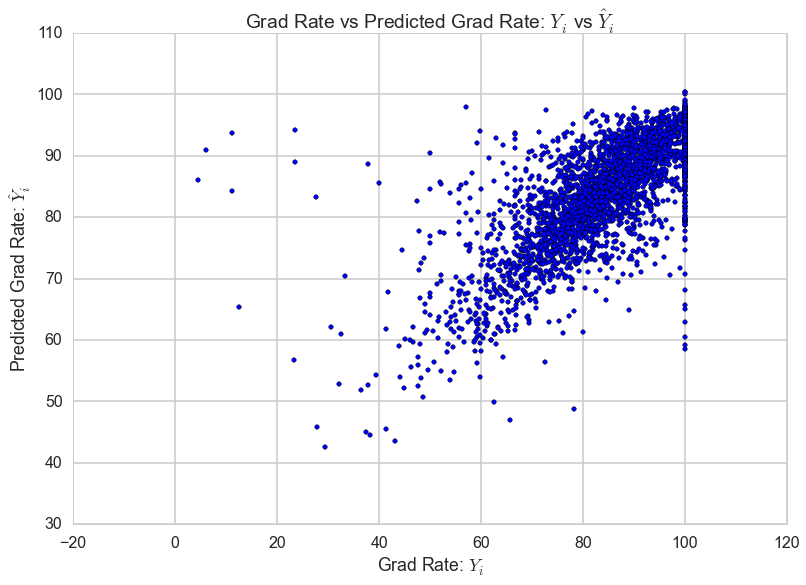

In [1699]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

Try to create a model that beats this.

In [1700]:
lcols=['r_stud_reg_12_W_F', 'r_stud_reg_12_W_M', 'tlocrev_percent', 'r_stud_re_W', 'r_lrev_pt', 'r_lunch_free', 'r_stud_re_B', 'tfedrev_percent', 'r_stud_18', 'tsrev_pp', 'tcuresal_percent', 'r_frev_title1', 'tcurinst_percent', 'r_lrev_molr']

In [1701]:
Xmatrix=dftouse[lcols].values
Yresp=dftouse['afgr'].values

In [1702]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [1703]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1704]:
print lm.intercept_
print lm.coef_

82.9736960637
[ 1.40672621  1.67746965  0.94894513 -0.14392126  0.50277151 -2.51218246
 -2.13005011 -1.04620389 -1.57373872 -0.80301383  0.79420606 -0.8472114
  0.31608269 -0.56324372]


In [1705]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,r_stud_reg_12_W_F,1.406726
1,r_stud_reg_12_W_M,1.677470
2,tlocrev_percent,0.948945
3,r_stud_re_W,-0.143921
4,r_lrev_pt,0.502772
5,r_lunch_free,-2.512182
6,r_stud_re_B,-2.130050
7,tfedrev_percent,-1.046204
8,r_stud_18,-1.573739
9,tsrev_pp,-0.803014


In [1706]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.32704793,  0.34484391,  0.37881015])

In [1707]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

115.30221556525113

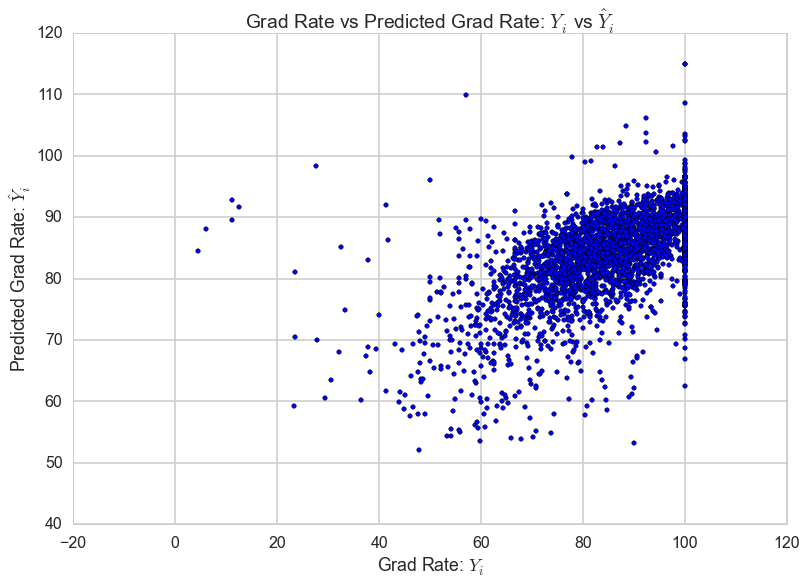

In [1708]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

### Findings

Linear Regression - 0607 Only and Best Model have very similar MSE.  The 0607 Only model overpredicts.  The Best Model underpredicts.  Underprediction is better than overprediction in this scenario - it is disadvantageous if the school district thinks it is performing better than it is.

This brings to mind an interesting scenario.  We started this project with 09-10 graduation data because it was the newest data available.  Given the similarity in the 0607 Only and Best model, if all we have is school district information, it may be worthwhile checking if we can predict with the same quality as the 0607 Only model.  If quality is similar, we might be able to predict 12-13 graduation rates several years before they are released to the public.

We go back to ELSI to download 0607 school district information to test this out.

## Trying 2009-2010 predictions using 2006-2007 data

In [1709]:
dftouse0607 = pd.read_csv("data/finaldata/dftouse_0607_with0910grad.csv")

In [1710]:
dftouse0607.shape

(9582, 417)

In [1711]:
STANDARDIZABLE = ['num_students', 'num_schools','num_charter_schools','num_pub_schools','tcuresal_percent','pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp','tlocrev_pp','tsrev_pp','tfedrev_pp','tcurinst_pp','tcurssv_pp','tcuroth_pp','tcursalary_pp','tcurbenefits_pp','totalexp_pp','tcapout_pp','tnonelse_pp','tcurelsc_pp','instexp_pp','tcurinst_percent','tcuroth_percent','tcurelsc_percent','tcurssvc_percent','tfedrev_percent','tlocrev_percent','tsrev_percent','r_ELL','r_IEP','r_lunch_free','r_lunch_reduced','r_stud_PKK','r_stud_18','r_stud_912','r_stud_re_M','r_stud_re_F','r_stud_re_AIAN','r_stud_re_AAP','r_stud_re_H','r_stud_re_B','r_stud_re_W','r_stud_re_Total','r_stud_reg_12_AIAN_M','r_stud_reg_12_AIAN_F','r_stud_reg_12_AAP_M','r_stud_reg_12_AAP_F','r_stud_reg_12_H_M','r_stud_reg_12_H_F','r_stud_reg_12_B_M','r_stud_reg_12_B_F','r_stud_reg_12_W_M','r_stud_reg_12_W_F','r_stud_reg_12_HNPI_M','r_stud_reg_12_HNPI_F','r_stud_reg_12_Two_M','r_stud_reg_12_Two_F','r_st_PKT','r_st_KT','r_st_ET','r_st_ST','r_st_UT','r_st_TS','r_st_IA','r_st_IC','r_st_EGC','r_st_SGC','r_st_TGC','r_st_LMS','r_st_LMSS','r_st_LEA','r_st_LEASS','r_st_SA','r_st_SASS','r_st_SSSS','r_st_OSSS','r_lrev_pt','r_lrev_gst','r_lrev_put','r_lrev_it','r_lrev_aot','r_lrev_pgc','r_lrev_cc','r_lrev_oss','r_lrev_tui','r_lrev_trans','r_lrev_slr','r_lrev_ts','r_lrev_sar','r_lrev_osalserv','r_lrev_sfns','r_lrev_ie','r_lrev_molr','r_lrev_sp','r_lrev_rr','r_lrev_sale','r_lrev_ff','r_lrev_pc','r_srev_gfa','r_srev_sep','r_srev_trans','r_srev_sip','r_srev_cbsp','r_srev_vep','r_srev_codsp','r_srev_bep','r_srev_gt','r_srev_slp','r_srev_aor','r_srev_splea','r_srev_osp','r_srev_ns','r_frev_title1','r_frev_dis','r_frev_cna','r_frev_ems','r_frev_dfs','r_frev_voc','r_frev_ao','r_frev_ns','r_frev_ia','r_frev_be','r_frev_na','r_frev_aofed']
print STANDARDIZABLE

['num_students', 'num_schools', 'num_charter_schools', 'num_pub_schools', 'tcuresal_percent', 'pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp', 'tlocrev_pp', 'tsrev_pp', 'tfedrev_pp', 'tcurinst_pp', 'tcurssv_pp', 'tcuroth_pp', 'tcursalary_pp', 'tcurbenefits_pp', 'totalexp_pp', 'tcapout_pp', 'tnonelse_pp', 'tcurelsc_pp', 'instexp_pp', 'tcurinst_percent', 'tcuroth_percent', 'tcurelsc_percent', 'tcurssvc_percent', 'tfedrev_percent', 'tlocrev_percent', 'tsrev_percent', 'r_ELL', 'r_IEP', 'r_lunch_free', 'r_lunch_reduced', 'r_stud_PKK', 'r_stud_18', 'r_stud_912', 'r_stud_re_M', 'r_stud_re_F', 'r_stud_re_AIAN', 'r_stud_re_AAP', 'r_stud_re_H', 'r_stud_re_B', 'r_stud_re_W', 'r_stud_re_Total', 'r_stud_reg_12_AIAN_M', 'r_stud_reg_12_AIAN_F', 'r_stud_reg_12_AAP_M', 'r_stud_reg_12_AAP_F', 'r_stud_reg_12_H_M', 'r_stud_reg_12_H_F', 'r_stud_reg_12_B_M', 'r_stud_reg_12_B_F', 'r_stud_reg_12_W_M', 'r_stud_reg_12_W_F', 'r_stud_reg_12_HNPI_M', 'r_stud_reg_12_HNPI_F', 'r_stud_reg_12_Two_M

In [1712]:
INDICATORS = []
for v in dftouse0607.columns:
    l=np.unique(dftouse0607[v])
    if len(l) <= 10:
        INDICATORS.append(v)
        
INDICATORS.remove('RESP_High_Graduation')        
INDICATORS.remove('RESP_Low_Graduation')  
INDICATORS.remove('Metro Status Code [District] 2009-10')
INDICATORS.remove('Gender Unknown Students [Public School] 2009-10')
print INDICATORS

['i_agency_type_local_school_district', 'i_agency_type_local_school_district_sup_union', 'i_agency_type_sup_union_admin', 'i_agency_type_regional_education_services', 'i_agency_type_state_operated_institution', 'i_agency_type_charter_school_agency', 'i_agency_type_other_education_agency', 'i_fin_sdlc_elem', 'i_fin_sdlc_sec', 'i_fin_sdlc_elem_sec', 'i_fin_sdlc_voc', 'i_fin_sdlc_nonop', 'i_fin_sdlc_ed_serv', 'i_ucl_city_large', 'i_ucl_city_mid', 'i_ucl_city_small', 'i_ucl_suburb_large', 'i_ucl_suburb_mid', 'i_ucl_suburb_small', 'i_ucl_town_fringe', 'i_ucl_town_distant', 'i_ucl_town_remote', 'i_ucl_rural_fringe', 'i_ucl_rural_distant', 'i_ucl_rural_remote', 'i_cs_all_charter', 'i_cs_charter_noncharter', 'i_cs_all_noncharter', 'i_ma_ne_nr', 'i_ma_metropolitan', 'i_ma_micropolitan', 'i_lgo_10', 'i_lgo_11', 'i_lgo_12', 'i_lgo_1', 'i_lgo_2', 'i_lgo_3', 'i_lgo_4', 'i_lgo_5', 'i_lgo_6', 'i_lgo_7', 'i_lgo_8', 'i_lgo_9', 'i_lgo_K', 'i_lgo_PK', 'i_lgo_U']


In [1713]:
itrain, itest = train_test_split(xrange(dftouse0607.shape[0]), train_size=0.7)

In [1714]:
#CITATION: From HW3
mask=np.ones(dftouse0607.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [1715]:
# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dftouse0607['afgr'][mask])
print "% Graduation in Testing:", np.mean(dftouse0607['afgr'][~mask])

% Graduation in Training: 81.4384970926
% Graduation in Testing: 81.3861565217


In [1716]:
#CITATION: From HW3
mask

array([False,  True,  True, ...,  True,  True, False], dtype=bool)

In [1717]:
#CITATION: From HW3
mask.shape, mask.sum()

((9582,), 6707)

In [1718]:
dftouse0607.head()

,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,﻿Agency Name_DEL,latitude,longitude,agency_id_state,Metro Status Code [District] 2009-10,congressional_code,census_id,offered_g_lowest,num_students,Total Students - Calculated Sum of Reported Grade Totals [Public School] 2009-10,Migrant Students in Summer Programs (**) [District] 2009-10,Migrant Students (**) [Public School] 2009-10,Gender Unknown Students [Public School] 2009-10,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,...,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,afgr0910
0,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER,42029,1,1,1,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,21ST CENTURY CYBER CS,40.002611,-75.689137,124150002,2-CBSA/MSA- not primarily its principal/centra...,4206,NaN,6th Grade,467,467,NaN,NaN,0,29.3,28.7,9011,8676,245,90,4426,2898,0,3394,1196,7785,461,0,7324,4426,16.3,60.4,0.0,46.3,39.6,1.0,...,0.000000,0,0.000000,0,0,0.00000,0.999017,0.000000,0,0.000000,0.000000,0.000000,0.000737,0,0.000000,0.000246,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.939130,0.000000,0.000000,0.000000,0,0,0.000000,0.060870,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1.000000,1,0,100.0
1,A+ ACADEMY,Texas,TX,4800203,DALLAS,48113,1,1,1,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,A+ ACADEMY,32.690593,-96.643398,057829,1-Principal/central city of CBSA/MSA,4830,NaN,Prekindergarten,994,994,NaN,NaN,0,13.5,13.5,9040,462,7798,781,4751,2960,362,5179,523,8072,0,0,8072,4751,6.5,58.8,4.5,64.2,36.7,8.6,...,0.000000,0,0.000000,0,0,0.00000,0.000000,0.000000,0,0.172113,0.000000,0.000000,0.000000,0,0.000000,0.827887,0.000000,0.000000,0.000000,0,0.000000,0.916398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000516,0.035221,0.041414,0.006451,0,0.000000,0.199742,0.355670,0.068299,0.001289,0.000000,0.375000,0,0,0,0,0.000000,0,0,55.7
2,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS,17017,3,0,3,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,A-C CENTRAL CUSD 262,39.891262,-90.010711,46-009-2620-26,3-Does not serve a CBSA/MSA,1718,1.450092e+13,Prekindergarten,483,483,NaN,0,0,10.3,10.3,9327,4292,4532,503,3950,3280,383,4826,1133,7857,27,0,7613,3950,14.9,51.9,5.0,63.4,43.1,5.4,...,0.000000,0,0.000000,0,0,0.00000,0.017366,0.000000,0,0.045345,0.010613,0.011577,0.000000,0,0.007718,0.010130,0.031838,0.000000,0.000000,0,0.000000,0.704888,0.031521,0.160347,0.000000,0.000000,0.005025,0.000000,0,0,0.000914,0.010964,0.081316,0.005025,0,0.263374,0.000000,0.238683,0.000000,0.004115,0.000000,0.288066,0,0,0,0,0.205761,1,0,70.7
3,A-H-S-T COMM SCHOOL DISTRICT,Iowa,IA,1904080,POTTAWATTAMIE,19155,2,0,2,1986-2013,NaN,768 SOUTH MAPLE ST,AVOCA,IA,51521,A-H-S-T COMM SCHOOL DISTRICT,41.471423,-95.341045,780441 000,2-CBSA/MSA- not primarily its principal/centra...,1905,1.650780e+13,Prekindergarten,605,605,NaN,0,0,13.5,13.5,10681,5056,5246,379,5028,2192,309,4864,1258,8712,1106,31,7529,5028,16.7,66.8,4.1,64.6,29.1,3.5,...,0.154299,0,0.073227,0,0,0.00000,0.059170,0.002288,0,0.039555,0.004904,0.001308,0.000000,0,0.016672,0.022

In [1719]:
#CITATION: From HW3
from sklearn.preprocessing import StandardScaler

for col in STANDARDIZABLE:
    #print col
    valstrain=dftouse0607[col].values[mask]
    valstest=dftouse0607[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse0607[col]=out

In [1720]:
dftouse0607.head()

,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,﻿Agency Name_DEL,latitude,longitude,agency_id_state,Metro Status Code [District] 2009-10,congressional_code,census_id,offered_g_lowest,num_students,Total Students - Calculated Sum of Reported Grade Totals [Public School] 2009-10,Migrant Students in Summer Programs (**) [District] 2009-10,Migrant Students (**) [Public School] 2009-10,Gender Unknown Students [Public School] 2009-10,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,...,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,afgr0910
0,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER,42029,-0.371580,0.520888,-0.369873,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,21ST CENTURY CYBER CS,40.002611,-75.689137,124150002,2-CBSA/MSA- not primarily its principal/centra...,4206,NaN,6th Grade,-0.264853,467,NaN,NaN,0,1.261785,2.464802,-0.512208,0.900911,-1.976640,-1.052414,-0.656777,-0.319036,-2.132368,-1.184245,-0.732236,-0.715373,-0.259812,-0.464517,-0.666519,-0.656765,-0.506801,0.019814,-2.277751,-1.538026,0.974131,-1.148318,...,-0.204152,-0.156908,-0.271036,-0.280887,-0.265781,-0.292201,9.313963,-0.204434,-0.183208,-1.113615,-0.313956,-0.578348,-0.217080,-0.058007,-0.797927,-0.510027,-0.276986,-0.242684,-0.161029,-0.320052,-0.247030,-3.341351,-0.577470,-0.512508,15.562227,-0.277813,-0.280114,-0.321228,-0.164654,-0.178047,-0.113601,-0.092593,-0.484977,-0.348036,-0.191916,-1.510198,-0.972667,-1.931862,-0.644769,-0.394794,-0.325272,-0.760000,-0.411022,-0.188369,-0.150442,-0.181699,8.755573,1,0,100.0
1,A+ ACADEMY,Texas,TX,4800203,DALLAS,48113,-0.387190,0.700726,-0.387131,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,A+ ACADEMY,32.690593,-96.643398,057829,1-Principal/central city of CBSA/MSA,4830,NaN,Prekindergarten,-0.252584,994,NaN,NaN,0,-0.125970,0.040037,-0.522544,-1.062519,0.830296,-0.072251,-0.523234,-0.306809,-0.215709,-0.287410,-1.380162,-0.664823,-0.554784,-0.379223,-0.467614,-0.530777,-2.107293,-0.174287,-0.001346,0.580287,0.384079,0.146431,...,-0.217679,-0.162912,-0.265831,-0.284164,-0.265723,-0.295476,-0.347860,-0.228839,-0.125821,3.573176,-0.303509,-0.524945,-0.270349,-0.106817,-0.748972,9.312547,-0.260827,-0.183905,-0.108405,-0.295816,-0.213253,0.797882,-0.570733,-0.496126,-0.326770,-0.286972,-0.289328,-0.307609,-0.159626,-0.193260,-0.356593,-0.319804,-0.014539,0.363646,-0.201253,-1.482992,0.047248,0.810009,0.556234,-0.268836,-0.291799,1.620637,-0.412609,-0.188288,-0.143623,-0.189391,-0.474880,0,0,55.7
2,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS,17017,-0.267905,-0.114640,-0.269114,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,A-C CENTRAL CUSD 262,39.891262,-90.010711,46-009-2620-26,3-Does not serve a CBSA/MSA,1718,1.450092e+13,Prekindergarten,-0.299524,483,NaN,0,0,-0.646698,-0.471014,-0.462281,-0.198286,-0.353396,-0.360042,-0.899325,-0.080098,-0.142428,-0.457959,-0.786999,-0.711102,-0.539496,-0.379223,-0.600906,-0.895729,-0.728844,-1.071925,0.259481,0.489708,1.461762,-0.369900,...,-0.217679,-0.162912,-0.265831,-0.284164,-0.265723,-0.295476,-0.191058,-0.228839,-0.125821,0.056809,2.122724,-0.322835,-0.270349,

In [1721]:
#CITATION: From HW3
lcols=STANDARDIZABLE+INDICATORS
print len(lcols)

170


In [1722]:
#CITATION: From HW3
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)
print len(ccols), len(INDICATORS)
ccols

124 46


['num_students',
 'num_schools',
 'num_charter_schools',
 'num_pub_schools',
 'tcuresal_percent',
 'pupil_teacher_ratio_dist',
 'pupil_teacher_ratio_ps',
 'totalrev_pp',
 'tlocrev_pp',
 'tsrev_pp',
 'tfedrev_pp',
 'tcurinst_pp',
 'tcurssv_pp',
 'tcuroth_pp',
 'tcursalary_pp',
 'tcurbenefits_pp',
 'totalexp_pp',
 'tcapout_pp',
 'tnonelse_pp',
 'tcurelsc_pp',
 'instexp_pp',
 'tcurinst_percent',
 'tcuroth_percent',
 'tcurelsc_percent',
 'tcurssvc_percent',
 'tfedrev_percent',
 'tlocrev_percent',
 'tsrev_percent',
 'r_ELL',
 'r_IEP',
 'r_lunch_free',
 'r_lunch_reduced',
 'r_stud_PKK',
 'r_stud_18',
 'r_stud_912',
 'r_stud_re_M',
 'r_stud_re_F',
 'r_stud_re_AIAN',
 'r_stud_re_AAP',
 'r_stud_re_H',
 'r_stud_re_B',
 'r_stud_re_W',
 'r_stud_re_Total',
 'r_stud_reg_12_AIAN_M',
 'r_stud_reg_12_AIAN_F',
 'r_stud_reg_12_AAP_M',
 'r_stud_reg_12_AAP_F',
 'r_stud_reg_12_H_M',
 'r_stud_reg_12_H_F',
 'r_stud_reg_12_B_M',
 'r_stud_reg_12_B_F',
 'r_stud_reg_12_W_M',
 'r_stud_reg_12_W_F',
 'r_stud_reg_12_

In [1723]:
Xmatrix=dftouse0607[lcols].values
Yresp=dftouse0607['afgr'].values

In [1724]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression

In [1725]:
import sklearn.linear_model
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1726]:
print lm.intercept_
print lm.coef_

29850308.3183
[  1.63209965e+00   8.47696530e+00   3.10836741e-01  -1.13484731e+01
   7.37819564e-01   1.53002453e-01   1.82571315e-01   1.95396402e+03
  -1.81759233e+03  -1.13135707e+03  -3.96615493e+02   3.33702823e+02
   2.16471758e+02   4.31815886e+01   7.33982250e-01  -2.23337826e+00
  -9.42454207e-01   3.56836783e-01   1.41919942e-01  -5.28926650e+02
  -5.00992542e+00   9.58249342e-01   5.33329033e-01   7.34833440e-01
   6.84074733e-01  -8.75467535e+00  -2.45268656e+01  -2.50332677e+01
  -1.76439430e-01  -7.97438966e-01  -2.75540164e+00  -3.34993509e-01
   4.11210129e-01  -1.70137980e+00   2.60571930e+00  -5.17633307e+09
  -5.01003838e+09   8.63376885e+09   3.04309068e+09   1.49194728e+10
   1.64367694e+10   2.35948982e+10   1.94411970e+09   3.46178893e-01
   2.46094281e-01  -5.27415060e-01   2.00103597e-01   3.29608470e-01
   1.93816490e-01   1.11546795e+00   9.34511096e-02   1.10026631e+00
  -3.17679298e-01   5.86163815e-03   1.86376697e-01   2.15667155e-02
   9.60365465e-02  -

In [1727]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:25]

,features,estimatedCoefficients
62,r_st_TS,5.501039e+11
41,r_stud_re_W,2.359490e+10
40,r_stud_re_B,1.643677e+10
39,r_stud_re_H,1.491947e+10
37,r_stud_re_AIAN,8.633769e+09
38,r_stud_re_AAP,3.043091e+09
42,r_stud_re_Total,1.944120e+09
125,i_agency_type_local_school_district_sup_union,2.249237e+07
124,i_agency_type_local_school_district,2.249237e+07
130,i_agency_type_other_education_agency,2.249237e+07


In [1728]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:25]

,features,estimatedCoefficients
75,r_st_OSSS,-1.218558e+11
61,r_st_UT,-1.008309e+11
73,r_st_SASS,-8.523263e+10
74,r_st_SSSS,-8.268008e+10
64,r_st_IC,-7.455689e+10
63,r_st_IA,-4.184665e+10
60,r_st_ST,-1.870821e+10
71,r_st_LEASS,-1.831998e+10
59,r_st_ET,-1.742849e+10
70,r_st_LEA,-1.454774e+10


In [1729]:
from sklearn import cross_validation
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([  3.99518398e-01,  -6.93181496e+07,   3.65204335e-01])

In [1730]:
from sklearn.metrics import mean_squared_error
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

1.1452308467169967e+23

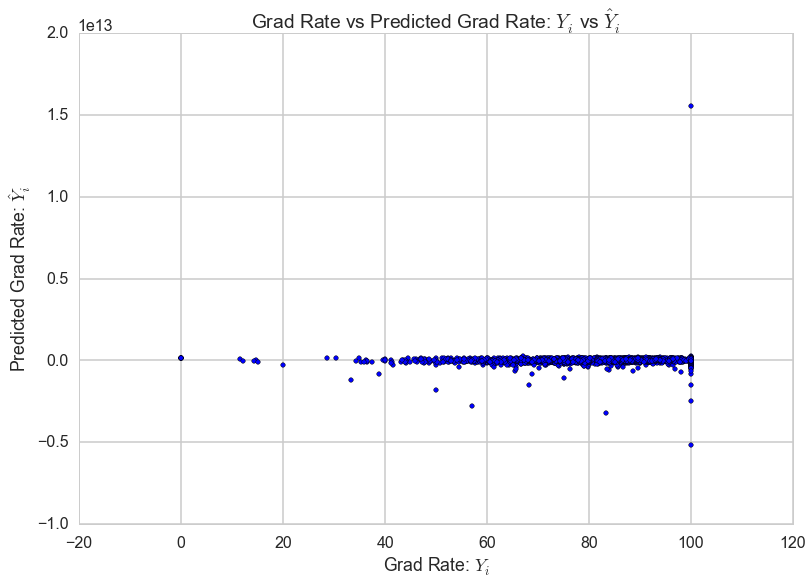

In [1731]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Lasso Regression

In [1732]:
lasso = linear_model.Lasso()

In [1733]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [1734]:
print lasso.coef_
print lasso.intercept_

[-0.         -0.         -0.         -0.14486977  0.054321   -0.          0.
 -0.          0.         -0.         -0.11957205  0.         -0.         -0.
  0.         -0.         -0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.         -0.47232839  0.92914893
 -0.         -0.         -0.17036654 -2.76154824  0.          0.         -0.
  1.05309155  0.          0.03956548  0.          0.         -0.
 -2.08035812  1.76663431  0.36093227  0.          0.          0.          0.
 -0.         -0.         -0.         -0.          0.47239104  0.          0.
  0.         -0.         -0.          0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.          0.          0.
  0.          0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.         -0.          0.         -0.          0.
  0.         -0

In [1735]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
41,r_stud_re_W,1.766634
34,r_stud_912,1.053092
26,tlocrev_percent,0.929149
51,r_stud_reg_12_W_M,0.472391
42,r_stud_re_Total,0.360932
4,tcuresal_percent,0.054321
36,r_stud_re_F,0.039565
113,r_frev_dis,0.000000
114,r_frev_cna,0.000000
115,r_frev_ems,0.000000


In [1736]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
30,r_lunch_free,-2.761548
40,r_stud_re_B,-2.080358
25,tfedrev_percent,-0.472328
29,r_IEP,-0.170367
3,num_pub_schools,-0.144870
10,tfedrev_pp,-0.119572
118,r_frev_ao,-0.068901
0,num_students,-0.000000
112,r_frev_title1,-0.000000
113,r_frev_dis,0.000000


In [1737]:
from sklearn import cross_validation
cross_validation.cross_val_score(lasso, Xtrain, ytrain, scoring='r2')

array([ 0.32359448,  0.29825506,  0.32375371])

In [1738]:
yp = lasso.predict(Xtest)
mean_squared_error(yp, ytest)

135.39615031660392

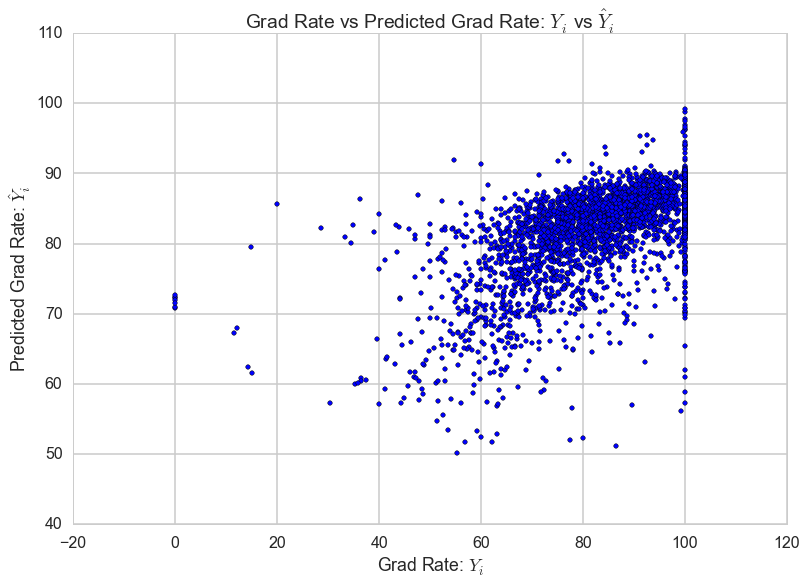

In [1739]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

In [1740]:
elasticnet = linear_model.ElasticNet()
elasticnet.fit(Xtrain, ytrain)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [1741]:
print elasticnet.coef_
print elasticnet.intercept_

[-0.         -0.26419914 -0.         -0.31814834  0.33232233 -0.
  0.03656942 -0.          0.         -0.12743654 -0.47140476 -0.         -0.
 -0.         -0.         -0.         -0.         -0.          0.         -0.
 -0.          0.34407387  0.         -0.         -0.09109065 -0.79324902
  0.82301949 -0.15627697 -0.15922091 -0.45916885 -1.7749695  -0.          0.
 -0.00536161  0.88728641  0.          0.26302968  0.          0.35032525
 -0.16258194 -1.58867117  1.3802804   0.36482158  0.08683189  0.10523747
  0.          0.08331541 -0.         -0.         -0.         -0.12787408
  0.69554767  0.4126116   0.          0.         -0.         -0.          0.
 -0.          0.          0.24756455  0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.29923852 -0.20462999
  0.          0.18784922  0.0307194  -0.11671171 -0.          0.          0.
 -0.          0.21288054 -0.   

In [1742]:
pd.DataFrame(zip(dftouse0607[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:20]

,features,estimatedCoefficients
41,r_stud_re_W,1.380280
34,r_stud_912,0.887286
26,tlocrev_percent,0.823019
51,r_stud_reg_12_W_M,0.695548
52,r_stud_reg_12_W_F,0.412612
42,r_stud_re_Total,0.364822
38,r_stud_re_AAP,0.350325
21,tcurinst_percent,0.344074
4,tcuresal_percent,0.332322
76,r_lrev_pt,0.299239


In [1743]:

pd.DataFrame(zip(dftouse0607[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:20]

,features,estimatedCoefficients
30,r_lunch_free,-1.774969
40,r_stud_re_B,-1.588671
25,tfedrev_percent,-0.793249
10,tfedrev_pp,-0.471405
29,r_IEP,-0.459169
3,num_pub_schools,-0.318148
118,r_frev_ao,-0.302406
1,num_schools,-0.264199
77,r_lrev_gst,-0.204630
106,r_srev_gt,-0.170984


In [1744]:
cross_validation.cross_val_score(elasticnet, Xtrain, ytrain, scoring='r2')

array([ 0.34785385,  0.31594856,  0.34646723])

In [1745]:
yp = elasticnet.predict(Xtest)
mean_squared_error(yp, ytest)

131.36396153469724

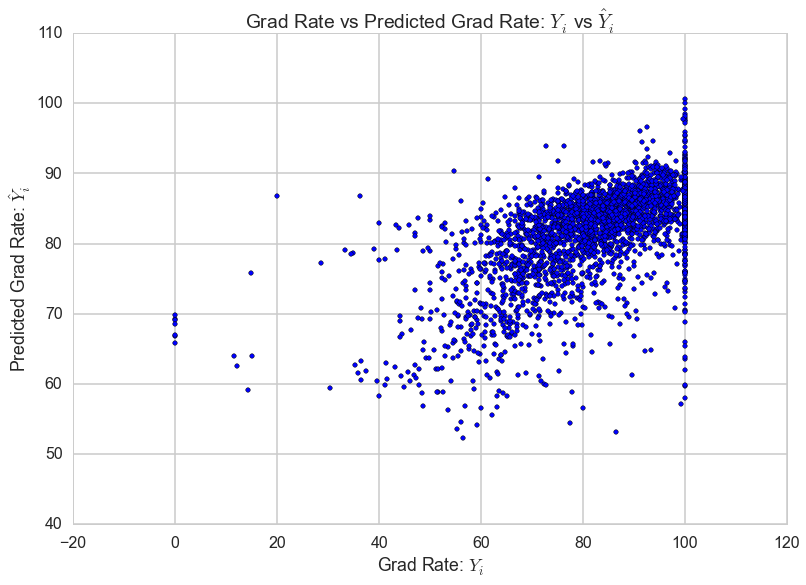

In [1746]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

Try to create a model that beats this.

In [1747]:
lcols=['r_stud_re_W','r_stud_912','r_stud_reg_12_W_M','tlocrev_percent','r_stud_re_Total','r_lunch_free','r_stud_re_B','tfedrev_percent','tfedrev_pp','r_frev_ao','r_stud_re_F','r_stud_reg_12_W_F','r_srev_gt','num_pub_schools']

In [1748]:
Xmatrix=dftouse0607[lcols].values
Yresp=dftouse0607['afgr'].values

In [1749]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [1750]:
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1751]:
print lm.intercept_
print lm.coef_

81.4384970926
[ 1.27807731  1.62997914  0.8888875   1.78997787  0.66999218 -2.99223513
 -2.75553597 -0.09324441 -0.97674417 -0.85047864  0.95069981 -0.11824181
 -0.67915717 -0.84982015]


In [1752]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,r_stud_re_W,1.278077
1,r_stud_912,1.629979
2,r_stud_reg_12_W_M,0.888888
3,tlocrev_percent,1.789978
4,r_stud_re_Total,0.669992
5,r_lunch_free,-2.992235
6,r_stud_re_B,-2.755536
7,tfedrev_percent,-0.093244
8,tfedrev_pp,-0.976744
9,r_frev_ao,-0.850479


In [1753]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.36076996,  0.30887076,  0.34939649])

In [1754]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

128.03123120633012

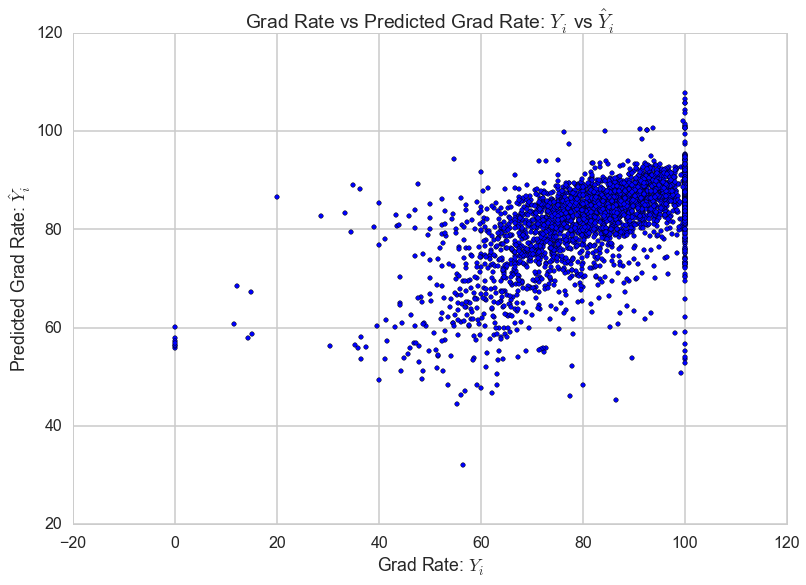

In [1755]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

Let's try predicting 2009-2010 graduation rate from 2006-2007 data.

In [1756]:
ActualX=dftouse[lcols].values
Actualy=dftouse['afgr'].values

In [1757]:
yp = lm.predict(ActualX)
mean_squared_error(yp, Actualy)

115.45348895449887

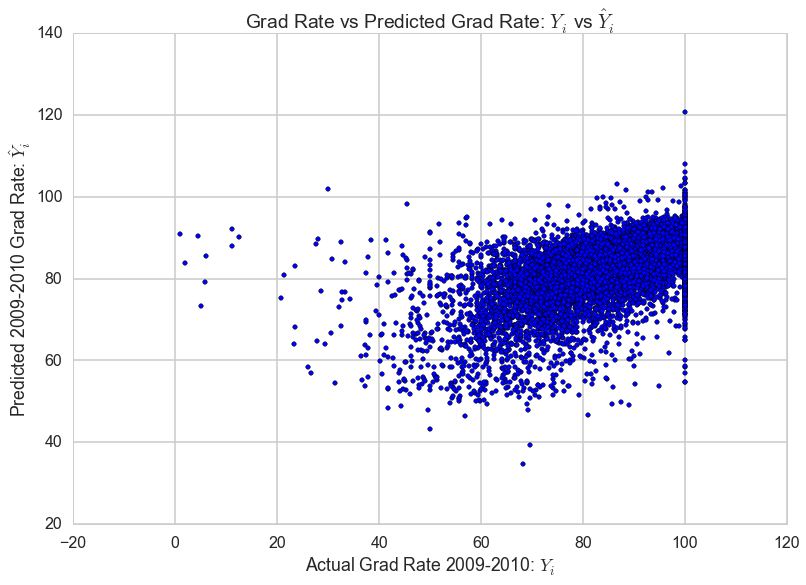

In [1758]:
plt.scatter(Actualy, yp)
plt.xlabel("Actual Grad Rate 2009-2010: $Y_i$")
plt.ylabel("Predicted 2009-2010 Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")